
<h1><center>Trends In Forest Recovery After Stand Replacing Disturbance: A Spectrotemporal Evaluation Of Productivity In Southeastern Pine Forests</center></h1>

<h4><center> Daniel J. Putnam </center></h4>

<center> For partial fulfillment of the reqiurements for the Master of Science degree </center>
<center> College of Natural Resources and Environment </center>
<center> Virginia Polytechnic Institute and State University </center>


## Analysis Preperation

### _Libraries_

In [1]:
import geemap
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from palettable.colorbrewer.diverging import RdYlGn_11 as NDVIpalette
from palettable.colorbrewer.sequential import YlOrRd_9 as LCMSpalette
ee.Initialize()

### _Imports_

In [2]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") # landsat 5
LS7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") # landsat 7
LS8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") # landsat 8
LCMS = ee.ImageCollection("USFS/GTAC/LCMS/v2020-5") # Landcover Change Monitoring System
NLCD_col = ee.ImageCollection("USGS/NLCD_RELEASES/2016_REL") # national landcover Database
STATES = ee.FeatureCollection("TIGER/2018/States") # state polygon boundaries (probably don't need anymore)
ecoRegions = ee.FeatureCollection("EPA/Ecoregions/2013/L3") # EPA Ecoregions
loblolly = ee.FeatureCollection("users/dputnam21/USFS_loblollyRange") # USFS loblolly pine range within states of interest

### _Priliminary set-up_

In [3]:
# Expirementing with colorbrewer palettes
## palettes = ee.data.require('users/gena/packages:palettes') ## going to need to replace this section of code
#NDVIpalette = palettes.colorbrewer.RdYlGn[9]
#LCMSpalette = palettes.colorbrewer.YlOrRd[9]

# Creating sample date range for disturbances
startingD = ee.Date.fromYMD(1995,1,1)
endingD = ee.Date.fromYMD(2010,12,31)

### _Landcover/Landuse Mask_

In [4]:
# New NLCD/LCMS method
# retrieve NLCD for each year
NLCD_2001 = NLCD_col.filter(ee.Filter.eq('system:index', '2001')).first().select("landcover")
NLCD_2004 = NLCD_col.filter(ee.Filter.eq('system:index', '2004')).first().select("landcover")
NLCD_2006 = NLCD_col.filter(ee.Filter.eq('system:index', '2006')).first().select("landcover")
NLCD_2008 = NLCD_col.filter(ee.Filter.eq('system:index', '2008')).first().select("landcover")
NLCD_2011 = NLCD_col.filter(ee.Filter.eq('system:index', '2011')).first().select("landcover")
NLCD_2013 = NLCD_col.filter(ee.Filter.eq('system:index', '2013')).first().select("landcover")
NLCD_2016 = NLCD_col.filter(ee.Filter.eq('system:index', '2016')).first().select("landcover")

# retrieve LCMS landuse classification
LCMSlanduseCol = LCMS.select("Land_Use")

# combine to image collection
NLCDlandcover_col = ee.ImageCollection(ee.List([NLCD_2001,NLCD_2004,NLCD_2006,NLCD_2008,NLCD_2011,NLCD_2013,NLCD_2016]))

# finding the most frequently identified landcover class
NLCDmode = NLCDlandcover_col.reduce(ee.Reducer.mode())
LCMSmode = LCMSlanduseCol.reduce(ee.Reducer.mode())

# combining the two layers into a mask
landCoverMask = LCMSmode.select('Land_Use_mode').eq(ee.Image(3))

# Pixels must have forest landuse classification from LCMS, and evergreen (NLCD), or woody wetland (NLCD)
landCoverMask = landCoverMask.updateMask(landCoverMask.And(NLCDmode.eq(ee.Image(42)) \
                                                           .Or(NLCDmode.eq(ee.Image(90))) \
                                                            ))

landCoverMask = landCoverMask.clip(loblolly) # clip mask to study boundaries for better loading

### _Landsat Preprocessing_

In [5]:
# Cloud masking based on the QA band : code taken from landsat example in data catalog in EE
def LScloudMask(image):
  qa = image.select('pixel_qa')
    # removing cloud pixels if confiance is high, cloud shadow, snow
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)) \
            .Or(qa.bitwiseAnd(1 << 3)) \
            .Or(qa.bitwiseAnd(1 << 4))
  return image.updateMask(cloud.Not())

# Going to try removing the coverage overlap between LS5 and LS8 to try and fix some issues
#LS5 = LS5.filterDate(start = '1984-01-01',opt_end = ee.Date('2013-04-11'))
#LS8 = LS8.filterDate(start = ee.Date('2013-04-11'))

# Lansat 5/7 & 8 differ in their band labeling, need to select the bands I'm going to use and rename them to
# match each other before merging collections : bands I need [red,green,NIR,SWIR1,SWIR2]    
LS8BandNames = ee.List(['B4','B3','B5','B6','B7','pixel_qa'])
NewBandNames = ee.List(['B3','B2','B4','B5','B7','pixel_qa'])
LS8 = LS8.select(LS8BandNames,NewBandNames)

# Adding a function to calculate and add an NDVI band for a single image
def addNDVI(image):
  ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
  return image.addBands(ndvi)

# Adding a function to calculate and add an NBR band for a single image.
def addNBR(image):
  nbr = image.normalizedDifference(['B4', 'B7']).rename('NBR')
  return image.addBands(nbr)

# Adding a function to calculate and add an MBI band for a single image.
def addMBI(image):
  MBI = image.expression(
  "MBI = ((b('B5') - b('B7') - b('B4')) / (b('B5') + b('B7') + b('B4'))) + 0.5")
  return image.addBands(MBI)

# adding the cloud mask per generation
LS5 = LS5.map(LScloudMask)
LS7 = LS7.map(LScloudMask)
LS8 = LS8.map(LScloudMask)

# merging the landsat 5 and 7 collections
LS_stack = LS5.merge(LS8)
LS_stack = LS_stack.merge(LS7)

# data reduction on the image stack
LS_stack = LS_stack.filterBounds(loblolly)

# Adding the indices to the filtered combined Landsat collection
LS_stack_wVI = LS_stack.map(addNDVI)
LS_stack_wVI = LS_stack_wVI.map(addNBR)
LS_stack_wVI = LS_stack_wVI.map(addMBI)

---

## Stand Selection Methods

### _LCMS Fast change method_

In [6]:
# Using the LCMS Change metric to identify harvest areas in contrast to the max VI method
# Filtering LCMS for the region and timeframe
LCMSchange = LCMS.select('Change')
LCMSchange = LCMSchange.filterDate(startingD,endingD)

# a function to apply the landcover mask to the LCMS image stack and select only fast change pixels
# also remaps values representing fast change to '1' and adds a band indicating year of disturbance
def NLCDmask(image):
    fastChange = image.updateMask(image.eq(3))
    fastChange = fastChange.remap([3],[1],bandName = 'Change')
    fastChangeMasked = fastChange.updateMask(landCoverMask)
    return fastChangeMasked

# applying the function to the LCMS
FC_stack = LCMSchange.map(NLCDmask)

### _Connected Pixel (Min stand size) mask_

In [7]:
# function to apply a connected pixel mask to the input image
def conectPixls(InImage,minArea,maxPixels):
    pixelCount = InImage.connectedPixelCount(maxPixels,False)
    minPixelCount = ee.Image(minArea).divide(ee.Image.pixelArea())
    outImage = InImage.updateMask(pixelCount.gte(minPixelCount))
    return outImage

# a function to be mapped accross an image collection and annually apply the connected pixels mask, also creates an
# additional band to store the year of disturbance for each pixel
def annualConectPixls(image):
    conectPixlsMasked = conectPixls(image,37800,250)
    imgYear = image.date().get('year')
    imgYearBand = ee.Image.constant(imgYear).uint16().rename('ChangeY')
    imgYearBand = imgYearBand.updateMask(conectPixlsMasked)
    return conectPixlsMasked.addBands(imgYearBand)

FC_final = FC_stack.map(annualConectPixls)

In [8]:
# creating the summary images
FC_final_changeN = FC_final.select('remapped').reduce(ee.Reducer.sum()) #.reproject(FC_stack.select('remapped').first().projection())
FC_final_1stYear = FC_final.select('ChangeY').reduce(ee.Reducer.min()) #.reproject(FC_stack.select('remapped').first().projection())

---

## New Automatic Stand Selection Method

### _Creating Sampling Areas Using Ecoregions_

In [9]:
# Limit ecoregions by overlap with loblolly range
loblollyEcoRegions = ecoRegions.filterBounds(loblolly)

# Function to convert the ecoregion code to an integer value
def convertPropertyToBand(feat):
    feat = ee.Feature(feat)
    prop = feat.get('us_l3code')
    propInt = ee.Number.parse(prop).toInt()
    feat = feat.set({'numericL3ecocode':propInt})
    return feat
loblollyEcoRegions = loblollyEcoRegions.map(convertPropertyToBand)

# Need to convert ecoregion feature collection and the property to integer in order for it to be used 
#     as the 'classBand' in the stratifiedSample fucntion
ecoregionImage = ee.Image(loblollyEcoRegions.reduceToImage(['numericL3ecocode'],ee.Reducer.first()))
ecoregionImage = ecoregionImage.cast({'first':'int8'})
ecoregionImage = ecoregionImage.clipToCollection(loblolly)

# An image representing pixels that are fast change and meet the landcover reqiurements
potentialSamples = FC_final_changeN.updateMask(FC_final_changeN.lte(2))

# Adding ecoregion code as band to potential sample pixels
potentialSamples = potentialSamples.addBands(ecoregionImage.select('first').rename('numericL3ecocode'))

### _Creating Random Sample Points_

In [ ]:
# Going to try just using the export table function to drive
samplePoints = potentialSamples.stratifiedSample(numPoints = 50,
                                                 region = loblolly,
                                                 classBand = 'numericL3ecocode',
                                                 scale = 30,
                                                 seed = 5,
                                                 dropNulls = True,
                                                 geometries = True,
                                                 )

# The export process will take about 15 minutes to complete
geemap.ee_export_vector_to_drive(samplePoints, 'stratifiedSamplePoints', 'EarthEngine_Exports', file_format='shp', selectors=None)

### _Imports/Exports of Created Data_

In [ ]:
# # Importing the points created in the above cell
# samplePoints = ee.FeatureCollection('users/dputnam21/stratifiedSamplePoints_03022022')

In [48]:
# Importing the points created in the above cell
samplePoints = ee.FeatureCollection('users/dputnam21/newSamplePoints')

---

### Displaying images on the map

In [49]:
# LCMS landcover palette
LCMSlcPalette = ['efff6b','ff2ff8','1b9d0c','97ffff','a1a1a1','c2b34a','1B1716']

Map = geemap.Map()
Map.centerObject(loblolly,7)

# This is the bottom of the layer order

Map.addLayer(ecoregionImage.select('first'), vis_params = {'palette': LCMSlcPalette, 'min': 45, 'max':75}, name = 'Ecoregion Code Image')
Map.addLayer(loblollyEcoRegions, name = 'Full ecoregion polygons')
Map.addLayer(loblolly, vis_params = {'color' :'red'}, name = 'Study Area', shown = False)
Map.addLayer(landCoverMask, vis_params = {'palette': ['white','2ca25f'], 'min' : 0, 'max' : 1}, name = 'new landcover mask', shown = False)
Map.addLayer(FC_final_1stYear,{'palette':['edf8b1','7fcdbb','2c7fb8'],'min' : 1995, 'max' : 2010},'LCMS Fast Change Year',False)
Map.addLayer(FC_final_changeN,{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':3},'LCMS Fast Change Count',False)
Map.addLayer(potentialSamples.select('remapped_sum'),{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':5}, name = 'Potential Sample Pixels', shown = False)
Map.addLayer(samplePoints,{'color':'red'}, name = 'Stratified Random Samples')

# This is the top of the layer order
Map.addLayerControl()
Map

Map(center=[33.55547594326177, -83.81053005836175], controls=(WidgetControl(options=['position', 'transparent_…

### Export of stand attributes

In [ ]:
# adding unique ID to each point

# Adding environmental variables as attributes for each stand


### New compositing method

In [50]:
# enter analysis parameters
compositeMonthN = 11
outputIndex = 'NBR'
compositeStat = 'median'

# prep for function
chart_VI = LS_stack_wVI.filter(ee.Filter.calendarRange(compositeMonthN,compositeMonthN,'month'));

years = ee.List.sequence(1984, 2020)

In [51]:
from datetime import datetime

start = datetime.now() # figuring out how long this takes to run

def perFeatureValueExtraction(index,comMonth,vegIndex,comStat) :
    
    aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('UniqueID', index)).first())
    inFeature = aFeature.geometry()

    local_chart_VI = chart_VI.filterBounds(inFeature)

    # A function to be mapped over a feature colllection, extracts 37 index values for each feature, returns them as a
    def seasonalReduction_extraction (y):
        filteredColl = local_chart_VI.filter(ee.Filter.calendarRange(y, y, 'year'))
        singleImage = filteredColl.select(['NDVI','NBR','MBI']).reduce(ee.Reducer.median()) ## CHANGE COMPOSITE STAT HERE ###
        outputImage = singleImage.set('system:time_start', ee.Date.fromYMD(y,comMonth, 1).millis())
        valDict = outputImage.reduceRegion(reducer = ee.Reducer.mean(), geometry = inFeature, scale = 30)
        NBRval = ee.Number(valDict.get(ee.String(vegIndex+'_'+compositeStat),defaultValue = 0.0))
        return ee.List([NBRval, 0.0]).reduce(ee.Reducer.firstNonNull())

    outputList = ee.List(years.map(seasonalReduction_extraction,False)).getInfo()
    return outputList

# calling the function
NumPlots = samplePoints.size().getInfo()
ListOfValLists = []

for index in range(NumPlots) :
    #aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('system:index', 0)).first())
    aList = perFeatureValueExtraction(index,compositeMonthN,outputIndex,compositeStat)
    ListOfValLists.append(aList)
    
end = datetime.now() # effectively ending the timer
duration = end - start

# nicely printing the ellapsed time
print('this function took this long to run :',duration,'\n')
timeList = str(duration).split(':')
print('The time elapsed during this execution of this operation was :','\n',
     timeList[0],'Hour(s)','\n',
     timeList[1],'Minute(s)','\n',
      'and',round(float(timeList[2]),ndigits = 0),'Seconds'
     )

# nicely displaying the raw data
standNum = 0
for alist in ListOfValLists :
    print('Stand',standNum,'\n',alist,'\n',('-'*124))
    standNum += 1

this function took this long to run : 1:17:43.240537 

The time elapsed during this execution of this operation was : 
 1 Hour(s) 
 17 Minute(s) 
 and 43.0 Seconds
Stand 0 
 [0.3313397467136383, 0, 0.32743361592292786, 0.42312368750572205, 0.3837471902370453, 0.392787903547287, 0, 0.3317972421646118, 0.5800948143005371, 0.6630286574363708, 0.08047182112932205, 0, 0, 0.23398759961128235, 0.19742615520954132, 0.2978222370147705, 0.3264283239841461, 0.27184727787971497, 0.5270630121231079, 0.4521774649620056, 0.38912078738212585, 0.4782602787017822, 0.4536123275756836, 0.41164857149124146, 0.37830448150634766, 0.4930323362350464, 0.4445520341396332, 0.36547812819480896, 0.42455559968948364, 0.4865350127220154, 0.4913063943386078, 0.6264463067054749, 0.57061368227005, 0.606967568397522, 0.49846720695495605, 0.6770126223564148, 0.6093264222145081] 
 ----------------------------------------------------------------------------------------------------------------------------
Stand 1 
 [0, 0, 0

In [56]:
# creating arrays for rows and columns of the table
stand_nums = range(0,samplePoints.size().getInfo())
imageYears = years.getInfo()
numYears = years.size().getInfo()

# client side replacement of null value (0.0) with null object
NDVIvals = ListOfValLists
for i in range(0,len(NDVIvals)):
    for i2 in range(0,numYears) :
        if NDVIvals[i][i2] == 0 :
            NDVIvals[i][i2] = None

In [57]:
# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

NDVItsDF = pd.DataFrame(index = stand_nums, columns = imageYears)
valIndex = 0
for r in range(0,len(stand_nums)):
    for c in range(0,len(imageYears)):
        NDVItsDF.iloc[r,c] = NDVIvals[r][c]
        valIndex += 1
        
for col in NDVItsDF:
    NDVItsDF[col] = pd.to_numeric(NDVItsDF[col], errors='coerce')
NDVItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.331340,NaN,0.327434,0.423124,0.383747,0.392788,NaN,0.331797,0.580095,0.663029,0.080472,NaN,NaN,0.233988,0.197426,0.297822,0.326428,0.271847,0.527063,0.452177,0.389121,0.478260,0.453612,0.411649,0.378304,0.493032,0.444552,0.365478,0.424556,0.486535,0.491306,0.626446,0.570614,0.606968,0.498467,0.677013,0.609326
1,NaN,NaN,NaN,NaN,0.435537,NaN,0.553670,NaN,NaN,NaN,0.524853,0.698113,0.613932,0.153612,0.208205,0.253268,0.325466,0.349968,NaN,0.476611,0.490062,0.585931,0.493356,0.469548,0.539933,0.493128,0.526618,0.644796,NaN,0.430822,0.574367,0.536402,0.656650,0.598233,0.608125,0.622636,0.578522
2,0.727769,0.787518,NaN,0.774474,0.763911,0.735157,0.703433,-0.037774,NaN,0.072677,0.175411,0.357902,0.510972,0.458509,0.494357,0.496811,0.596362,0.527618,0.646223,0.654281,0.718795,0.667594,0.662152,0.629562,0.546802,0.570161,0.656557,0.709292,0.651229,0.688924,0.643450,0.699019,0.771712,0.729680,0.774209,0.699235,0.732697
3,NaN,NaN,NaN,NaN,0.227648,NaN,0.353821,NaN,0.269105,NaN,0.274468,0.310683,0.296809,0.471526,0.262929,0.471567,0.008061,0.073785,0.259816,0.297674,0.453543,0.443664,0.514277,0.720143,0.697186,0.674074,0.671628,0.729382,NaN,0.555439,0.602460,0.667449,0.604017,0.650004,0.585104,0.631210,0.613859
4,NaN,NaN,0.592960,0.409058,0.542718,0.537986,NaN,0.600469,0.542159,0.604538,0.569451,0.603215,0.632653,0.603307,0.551771,0.576424,0.566304,0.548605,0.653473,0.510874,0.517339,0.575067,0.452268,0.324027,0.358990,0.395713,0.401174,0.637470,0.593438,0.575292,0.627600,0.735727,0.756844,0.765778,0.789155,0.727148,0.718047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,0.555927,0.616720,NaN,0.512772,0.582351,NaN,NaN,NaN,NaN,NaN,0.617329,0.403619,0.335275,NaN,NaN,0.392844,0.425321,0.403915,NaN,0.480885,0.492471,0.491002,0.451834,NaN,0.234083,0.431038,0.406883,0.275411,0.388083,0.541606,0.354035,0.457551,0.502922,0.523342,0.585443,0.548953,0.599838
519,NaN,0.673169,NaN,0.691334,0.718687,NaN,0.402196,0.512170,0.612355,NaN,0.313662,0.413221,0.497089,0.497146,0.531330,0.555017,0.578803,0.632011,0.687058,0.676768,0.713691,0.623549,0.210389,0.437789,0.443377,0.508215,0.611443,0.560899,0.666929,0.694192,0.664625,0.638500,0.679182,0.660870,0.699779,0.710382,0.684514
520,0.528483,0.379761,0.327819,0.562270,0.562207,NaN,0.450328,NaN,0.494441,NaN,0.546973,0.540076,0.626117,0.311301,0.358352,0.603455,0.692123,0.578425,0.417196,0.721718,0.572772,0.111285,0.183318,0.288709,0.269923,0.362496,0.301285,0.401733,0.281637,0.345054,0.346883,0.517457,0.630322,0.671171,0.376351,0.664819,0.637712
521,0.660789,NaN,NaN,0.616075,0.633102,NaN,0.687978,0.596801,0.647994,0.558480,0.601158,0.651573,0.550002,0.637856,0.634624,0.600513,0.630769,0.621411,0.633789,0.611179,0.611624,0.474468,0.431464,0.274065,0.417778,0.456488,0.598153,0.567282,0.467888,0.630793,0.625864,0.639653,0.699839,0.718759,NaN,0.710552,0.682688


### Creating time series plots

Text(0.06, 0.5, 'NBR value')

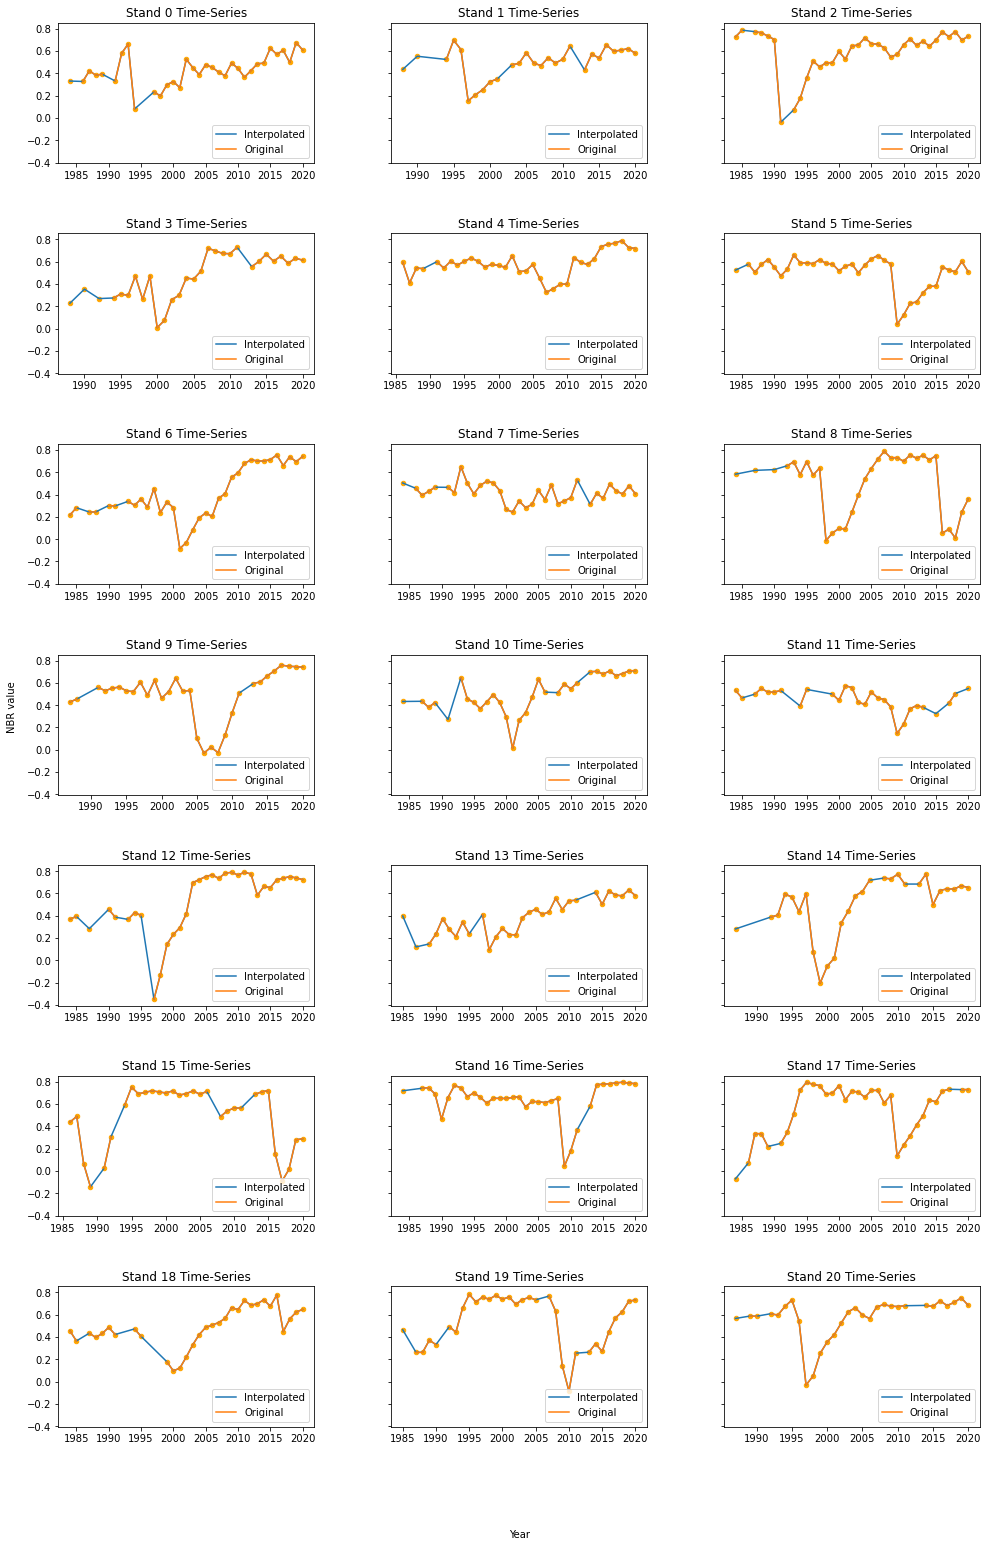

In [58]:
%matplotlib inline
import scipy as sp
import scipy.signal as scisig

# interpolation of null values
plotDF = NDVItsDF.interpolate(axis = 'columns',method = 'linear')

# setting up for time-series plots
fig, axs = plt.subplots(7, 3, sharex=False, sharey=True, figsize = (16,25))

for i, ax in enumerate(fig.axes):
    ax.plot(plotDF.iloc[i,].transpose(),label = "Interpolated")
    ax.plot(NDVItsDF.iloc[i,].transpose(),label = "Original")
    ax.scatter(imageYears,NDVItsDF.iloc[i,], color = 'orange',s = 20)
    ax.legend(loc='lower right')
    ax.set_title("Stand"+' '+str(i)+' '+"Time-Series")
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.3, hspace=0.5)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, (outputIndex+' '+'value'), ha='center', va='center', rotation='vertical')

In [59]:
plotDF

plotDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')